In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series

## GroupBy Mechanics

*split-apply-combine*

In the first stage of the process, data contained in a pandas object, whether a Series, DataFrame, or otherwise, is **split** into groups based on one or more keys that you provide. The splitting is performed on a particular axis of an object. For example, a DataFrame can be grouped on its rows (axis=0) or its columns (axis=1). Once this is done, a function is **applied** to each group, producing a new value. Finally, the results of all those function applications are **combined** into a result object.

In [2]:
df = DataFrame({"key": list("ABCABCABC"), "data": [0, 5, 10, 5, 10, 15, 10, 15, 20]})
df

,data,key
0,0,A
1,5,B
2,10,C
3,5,A
4,10,B
5,15,C
6,10,A
7,15,B
8,20,C


In [3]:
grouped = df.groupby("key") # Map
list(grouped)

[('A',    data key
  0     0   A
  3     5   A
  6    10   A), ('B',    data key
  1     5   B
  4    10   B
  7    15   B), ('C',    data key
  2    10   C
  5    15   C
  8    20   C)]

In [4]:
list(grouped)[0][0]

'A'

In [5]:
list(grouped)[0][1]

,data,key
0,0,A
3,5,A
6,10,A


In [6]:
grouped.apply(lambda x: sum(x["data"])) # Reduce

key
A    15
B    30
C    45
dtype: int64

In [7]:
df = DataFrame({"key1": list("aabba"),
                "key2": ["one", "two", "one", "two", "one"],
                "data1": np.random.randn(5),
                "data2": np.random.randn(5)})
df

,data1,data2,key1,key2
0,0.583317,-0.177219,a,one
1,0.532088,-0.863464,a,two
2,-0.969299,1.013259,b,one
3,-1.136269,1.816477,b,two
4,-0.723753,0.124589,a,one


Compute the mean of the **data1** column using the groups labels from **key1**

In [8]:
grouped = df["data1"].groupby(df["key1"])
grouped

In [9]:
list(grouped)

[('a', 0    0.583317
  1    0.532088
  4   -0.723753
  Name: data1, dtype: float64), ('b', 2   -0.969299
  3   -1.136269
  Name: data1, dtype: float64)]

This **grouped** variable is now a *GroupBy* object. It has all of the information needed to then apply some operation to each of the groups. To compute group means we can call the GroupBy's **mean** method:

In [10]:
grouped.mean()

key1
a    0.130550
b   -1.052784
Name: data1, dtype: float64

The data **df["data1"]** (a Series) has been aggregated according to the group key, producing a new Series that is now indexed by the unique values in the **key1** column.

If we had passed multiple arrays as a list, we get something different:

In [11]:
means = df["data1"].groupby([df["key1"], df["key2"]]).mean()
means

key1  key2
a     one    -0.070218
      two     0.532088
b     one    -0.969299
      two    -1.136269
Name: data1, dtype: float64

In this case, we grouped the data using two keys, and the resulting Series now has a hierarchical index consisting of the unique pairs of keys observed:

In [12]:
means.unstack()

key2,one,two
key1,,
a,-0.070218,0.532088
b,-0.969299,-1.136269


In these examples, the group keys (parameters of **groupby**) are all Series, though they could be any arrays of the right length:

In [13]:
states = np.array(["Ohio", "California", "California", "Ohio", "Ohio"])
years = np.array([2005, 2005, 2006, 2005, 2006])
df

,data1,data2,key1,key2
0,0.583317,-0.177219,a,one
1,0.532088,-0.863464,a,two
2,-0.969299,1.013259,b,one
3,-1.136269,1.816477,b,two
4,-0.723753,0.124589,a,one


In [14]:
df["data1"].groupby([states, years]).mean()

California  2005    0.532088
            2006   -0.969299
Ohio        2005   -0.276476
            2006   -0.723753
Name: data1, dtype: float64

Usually, the grouping information (**key1**) can be found in the same DataFrame (**df**) as the data. In this case, you can pass column names as the group keys:

In [15]:
df.groupby("key1").mean()

,data1,data2
key1,,
a,0.130550,-0.305365
b,-1.052784,1.414868


In the result above, **key2** was left out because it's not numeric data.

In [16]:
df.groupby(["key1", "key2"]).mean()

data1     data2
key1 key2                    
a    one  -0.070218 -0.026315
     two   0.532088 -0.863464
b    one  -0.969299  1.013259
     two  -1.136269  1.816477

Lastly, find the group sizes:

In [17]:
df.groupby(["key1", "key2"]).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

### Iterating Over Groups

The GroupBy obejct supports iteration, generating a sequence of 2-tuples containing the group name along with the chunk of data:

In [18]:
df

,data1,data2,key1,key2
0,0.583317,-0.177219,a,one
1,0.532088,-0.863464,a,two
2,-0.969299,1.013259,b,one
3,-1.136269,1.816477,b,two
4,-0.723753,0.124589,a,one


In [19]:
for name, group in df.groupby("key1"):
    print name
    print group

a
      data1     data2 key1 key2
0  0.583317 -0.177219    a  one
1  0.532088 -0.863464    a  two
4 -0.723753  0.124589    a  one
b
      data1     data2 key1 key2
2 -0.969299  1.013259    b  one
3 -1.136269  1.816477    b  two


In the case of multiple keys, the first element in the tuple will be a tuple of key values:

In [20]:
for (k1, k2), group in df.groupby(["key1", "key2"]):
    print k1, k2
    print group

a one
      data1     data2 key1 key2
0  0.583317 -0.177219    a  one
4 -0.723753  0.124589    a  one
a two
      data1     data2 key1 key2
1  0.532088 -0.863464    a  two
b one
      data1     data2 key1 key2
2 -0.969299  1.013259    b  one
b two
      data1     data2 key1 key2
3 -1.136269  1.816477    b  two


Compute a dict of the data pieces as a one-liner:

In [21]:
pieces = dict(list(df.groupby("key1")))
pieces["b"]

,data1,data2,key1,key2
2,-0.969299,1.013259,b,one
3,-1.136269,1.816477,b,two


By default **groupby** groups on **axis=0**, but you can group on any of the other axes.

For example, we could group the columns of our example **df** here by **dtype** like so:

In [22]:
df

,data1,data2,key1,key2
0,0.583317,-0.177219,a,one
1,0.532088,-0.863464,a,two
2,-0.969299,1.013259,b,one
3,-1.136269,1.816477,b,two
4,-0.723753,0.124589,a,one


In [23]:
df.dtypes

data1    float64
data2    float64
key1      object
key2      object
dtype: object

In [24]:
grouped = df.groupby(df.dtypes, axis=1)

In [25]:
list(grouped)

[(dtype('float64'),       data1     data2
  0  0.583317 -0.177219
  1  0.532088 -0.863464
  2 -0.969299  1.013259
  3 -1.136269  1.816477
  4 -0.723753  0.124589), (dtype('O'),   key1 key2
  0    a  one
  1    a  two
  2    b  one
  3    b  two
  4    a  one)]

### Selecting a Column of Subset of Columns

Indexing a GroupBy object created from a DataFrame with a column name or array of column names has the effect of *selecting those columns for aggregation*:

In [26]:
df

,data1,data2,key1,key2
0,0.583317,-0.177219,a,one
1,0.532088,-0.863464,a,two
2,-0.969299,1.013259,b,one
3,-1.136269,1.816477,b,two
4,-0.723753,0.124589,a,one


In [27]:
list(df.groupby("key1")["data1"])

[('a', 0    0.583317
  1    0.532088
  4   -0.723753
  Name: data1, dtype: float64), ('b', 2   -0.969299
  3   -1.136269
  Name: data1, dtype: float64)]

In [28]:
list(df["data1"].groupby(df["key1"]))

[('a', 0    0.583317
  1    0.532088
  4   -0.723753
  Name: data1, dtype: float64), ('b', 2   -0.969299
  3   -1.136269
  Name: data1, dtype: float64)]

For **large** datasets, it may be desirable to aggregate only a few columns:

The object returned by this indexing operation is a grouped DataFrame if a list or array is passed (i.e. [["data2"]])

In [29]:
df.groupby(["key1", "key2"])[["data2"]].mean()

data2
key1 key2          
a    one  -0.026315
     two  -0.863464
b    one   1.013259
     two   1.816477

Or a grouped Series if a single column name (["data2"]) is passed

In [30]:
s_grouped = df.groupby(["key1", "key2"])["data2"]
s_grouped

In [31]:
s_grouped.mean()

key1  key2
a     one    -0.026315
      two    -0.863464
b     one     1.013259
      two     1.816477
Name: data2, dtype: float64

### Grouping with Dicts and Series

In [32]:
people = DataFrame(np.random.randn(5, 5),
                   columns=list("abcde"),
                   index=["Joe", "Steve", "Wes", "Jim", "Travis"])
people

,a,b,c,d,e
Joe,-0.085232,1.371453,-0.756601,-1.204335,-0.558264
Steve,0.183243,-0.261993,-0.049941,-0.626277,-0.623247
Wes,-0.375326,0.814511,-1.301461,1.167277,-0.750363
Jim,0.721968,-1.472715,-1.102222,-0.692739,-0.155561
Travis,0.241322,0.352088,0.336593,0.000170,1.114763


In [33]:
people.ix[2:3, ["b", "c"]] = np.nan
people

,a,b,c,d,e
Joe,-0.085232,1.371453,-0.756601,-1.204335,-0.558264
Steve,0.183243,-0.261993,-0.049941,-0.626277,-0.623247
Wes,-0.375326,NaN,NaN,1.167277,-0.750363
Jim,0.721968,-1.472715,-1.102222,-0.692739,-0.155561
Travis,0.241322,0.352088,0.336593,0.000170,1.114763


Suppose there is a group correspondence for the columns and want to sum togetther the columns by group:

In [34]:
mapping = {"a": "red", "b": "red", "c": "blue",
           "d": "blue", "e": "red", "f": "orange"}

by_column = people.groupby(mapping, axis=1) # group by column (axis=1), using dict correspondence
by_column.sum()

,blue,red
Joe,-1.960936,0.727958
Steve,-0.676218,-0.701997
Wes,1.167277,-1.125689
Jim,-1.794962,-0.906308
Travis,0.336763,1.708172


The same functionality holds for Series. When Series is used as group keys in the above examples, pandas insepcts each Series to ensure that its index is aligned with the axis it's grouping:

In [35]:
map_series = Series(mapping)
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [36]:
people.groupby(map_series, axis=1).count() # NA values are not included

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


### Grouping with Functions

Any **function** passed as a group key will be called once per index value, with the return values being used as the group names.

Suppose you want to group by the length of the names of people; you could compute an array of string lengths, by passing the **len** function:

people

In [37]:
people.groupby(len).sum()

,a,b,c,d,e
3,0.261411,-0.101261,-1.858823,-0.729797,-1.464188
5,0.183243,-0.261993,-0.049941,-0.626277,-0.623247
6,0.241322,0.352088,0.336593,0.000170,1.114763


**Mixing** functions with arrays, dicts, or Series as group keys:

In [38]:
key_list = ["one", "one", "one", "two", "two"]
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one -0.375326  1.371453 -0.756601 -1.204335 -0.750363
  two  0.721968 -1.472715 -1.102222 -0.692739 -0.155561
5 one  0.183243 -0.261993 -0.049941 -0.626277 -0.623247
6 two  0.241322  0.352088  0.336593  0.000170  1.114763

### Grouping by Index Levels

A convenience for hierarchically-indexed datasets is the ability to aggregate using one of the levels of an axis index.

To do this, pass the level number of name (**level="cty"**) using the **level** keyword:

In [39]:
columns = pd.MultiIndex.from_arrays([["US", "US", "US", "JP", "JP"],
                                     [1, 3, 5, 1, 3]], names=["cty", "tenor"])
hier_df = DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.292012  1.183493  0.815820 -0.021032  1.334421
1     -0.670529  1.916255  1.300650  0.066027 -1.988457
2     -1.362374  0.816597  2.585842  1.177995  0.547443
3     -0.377129  0.396291 -0.425373  0.591059  1.060283

In [40]:
hier_df.groupby(level="cty", axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


In [41]:
hier_df.groupby(level="cty", axis=1).max()

cty,JP,US
0,1.334421,1.183493
1,0.066027,1.916255
2,1.177995,2.585842
3,1.060283,0.396291


## Data Aggregation

**Aggregation** means any data transformation that produces scalar values from arrays (like **reduce** in MapReduce, e.g. mean(), count(), min(), and sum())

In [42]:
df

,data1,data2,key1,key2
0,0.583317,-0.177219,a,one
1,0.532088,-0.863464,a,two
2,-0.969299,1.013259,b,one
3,-1.136269,1.816477,b,two
4,-0.723753,0.124589,a,one


In [43]:
grouped = df.groupby("key1")
grouped["data1"].quantile(0.9)

key1
a    0.573071
b   -0.985996
Name: data1, dtype: float64

While **quantile** is not explicitly implemented for GroupBy, it is a Series method and thus available for use. Internally, GroupBy efficiently slices up the Series, calls piece.quantile(0.9) for each **piece**, then assembles those results together into the result object.

To use your own aggregation functions, pass any function that aggregates an array to the **aggregate** or **agg** method:

In [44]:
def peak_to_peak(arr):
    # arr is Series
    return arr.max() - arr.min()

df.groupby("key1").agg(peak_to_peak)

,data1,data2
key1,,
a,1.30707,0.988053
b,0.16697,0.803218


**describe()** on DataFrameGroupBy:

In [45]:
grouped.describe()

data1     data2
key1                          
a    count  3.000000  3.000000
     mean   0.130550 -0.305365
     std    0.740292  0.506338
     min   -0.723753 -0.863464
     25%   -0.095833 -0.520342
     50%    0.532088 -0.177219
     75%    0.557702 -0.026315
     max    0.583317  0.124589
b    count  2.000000  2.000000
     mean  -1.052784  1.414868
     std    0.118066  0.567961
     min   -1.136269  1.013259
     25%   -1.094526  1.214063
     50%   -1.052784  1.414868
     75%   -1.011041  1.615673
     max   -0.969299  1.816477

**NOTE**: user-defined aggregate functions could be much slower than optimized functions

**Advanced aggregation features:**

"Tips" dataset

First, add a tipping percentage column **tip_pct**

In [46]:
tips = pd.read_csv("tips.csv")

tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [47]:
tips["tip_pct"] = tips["tip"] / tips["total_bill"]

tips.head()

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808


### Column-wise and Multiple Function Application

Aggregate using a different function depending on the column

In [48]:
grouped = tips.groupby(["sex", "smoker"])
grouped_pct = grouped["tip_pct"]

In [49]:
grouped_pct.mean()

sex     smoker
Female  No        0.156921
        Yes       0.182150
Male    No        0.160669
        Yes       0.152771
Name: tip_pct, dtype: float64

In [50]:
grouped_pct.agg('mean') # pass the name of the function as a string

sex     smoker
Female  No        0.156921
        Yes       0.182150
Male    No        0.160669
        Yes       0.152771
Name: tip_pct, dtype: float64

In [51]:
grouped_pct.agg(["mean", "std", peak_to_peak]) # pass a list of functions or function names instead

mean       std  peak_to_peak
sex    smoker                                  
Female No      0.156921  0.036421      0.195876
       Yes     0.182150  0.071595      0.360233
Male   No      0.160669  0.041849      0.220186
       Yes     0.152771  0.090588      0.674707

In [52]:
a = lambda x: x*2 
a.__name__ # name of lambda function

'<lambda>'

In [53]:
grouped_pct.agg([("foo", "mean"), ("bar", np.std)]) 
# pass a list of (name, function) tuples

foo       bar
sex    smoker                    
Female No      0.156921  0.036421
       Yes     0.182150  0.071595
Male   No      0.160669  0.041849
       Yes     0.152771  0.090588

With a DataFrame, you have more options as you can specify a list of functions to apply to all of the columns or different functions per column:

In [54]:
functions = ["count", "mean", "max"]
result = grouped["tip_pct", "total_bill"].agg(functions)
result

tip_pct                     total_bill                  
                count      mean       max      count       mean    max
sex    smoker                                                         
Female No          54  0.156921  0.252672         54  18.105185  35.83
       Yes         33  0.182150  0.416667         33  17.977879  44.30
Male   No          97  0.160669  0.291990         97  19.791237  48.33
       Yes         60  0.152771  0.710345         60  22.284500  50.81

In [55]:
functions = ["count", "mean", "max"]
result = grouped["tip_pct", "total_bill"].aggregate(functions)
result

tip_pct                     total_bill                  
                count      mean       max      count       mean    max
sex    smoker                                                         
Female No          54  0.156921  0.252672         54  18.105185  35.83
       Yes         33  0.182150  0.416667         33  17.977879  44.30
Male   No          97  0.160669  0.291990         97  19.791237  48.33
       Yes         60  0.152771  0.710345         60  22.284500  50.81

The resulting DataFrame has hierachical columns, the same as you would get aggregating each column separately and using **concat** to glue the results together using the column names as the **keys** argument:

In [56]:
pd.concat([grouped["tip_pct"].agg(functions),
          grouped["total_bill"].agg(functions)], axis=1, keys=["tip_pct", "total_bill"])

tip_pct                     total_bill                  
                count      mean       max      count       mean    max
sex    smoker                                                         
Female No          54  0.156921  0.252672         54  18.105185  35.83
       Yes         33  0.182150  0.416667         33  17.977879  44.30
Male   No          97  0.160669  0.291990         97  19.791237  48.33
       Yes         60  0.152771  0.710345         60  22.284500  50.81

A list of tuples with custom names can be passed:

In [57]:
ftuples = [("Durchschnitt", "mean"), ("Abweichung", np.var)]
grouped["tip_pct", "total_bill"].agg(ftuples)

tip_pct              total_bill           
              Durchschnitt Abweichung Durchschnitt Abweichung
sex    smoker                                                
Female No         0.156921   0.001327    18.105185  53.092422
       Yes        0.182150   0.005126    17.977879  84.451517
Male   No         0.160669   0.001751    19.791237  76.152961
       Yes        0.152771   0.008206    22.284500  98.244673

Suppose you wanted to apply potentially different functions to one or more of the columns.

Pass a **dict** to **agg** that contains a mapping of column names to any of the function specifications listed:

In [58]:
grouped.agg({"tip": np.max, "size": "sum"}) # different functions on different columns

tip  size
sex    smoker            
Female No       5.2   140
       Yes      6.5    74
Male   No       9.0   263
       Yes     10.0   150

A DataFrame will have hierarchical columns only if multiple functions are applied to at least one column:

In [59]:
grouped.agg({"tip_pct": ["min", "max", "mean", "std"],
             "size": "sum"}) # different functions on different columns

tip_pct                               size
                    min       max      mean       std  sum
sex    smoker                                             
Female No      0.056797  0.252672  0.156921  0.036421  140
       Yes     0.056433  0.416667  0.182150  0.071595   74
Male   No      0.071804  0.291990  0.160669  0.041849  263
       Yes     0.035638  0.710345  0.152771  0.090588  150

### Returning Aggregated Data in "unindexed" Form

So far, the aggregated data comes back with an index, potentially hierarchical, composed from the unique group key combinations observed.

**Disable this behavior** in most cases by passing **as_index=False** to **groupby**:

In [60]:
tips.groupby(["sex", "smoker"], as_index=False).mean() # use as_index=False

,sex,smoker,total_bill,tip,size,tip_pct
0,Female,No,18.105185,2.773519,2.592593,0.156921
1,Female,Yes,17.977879,2.931515,2.242424,0.182150
2,Male,No,19.791237,3.113402,2.711340,0.160669
3,Male,Yes,22.284500,3.051167,2.500000,0.152771


In [61]:
tips.groupby(["sex", "smoker"]).mean().reset_index() # Or use reset_index)()

,sex,smoker,total_bill,tip,size,tip_pct
0,Female,No,18.105185,2.773519,2.592593,0.156921
1,Female,Yes,17.977879,2.931515,2.242424,0.182150
2,Male,No,19.791237,3.113402,2.711340,0.160669
3,Male,Yes,22.284500,3.051167,2.500000,0.152771


### Group-wise Operations and Transformations

Aggregation: reduce a one-dimensional array to a scalar value, a **special case** of general data **transformation**

Suppose we wanted to add a column to a DataFrame containing group means for each index. One way to do this is to aggregate, then merge:

In [62]:
df

,data1,data2,key1,key2
0,0.583317,-0.177219,a,one
1,0.532088,-0.863464,a,two
2,-0.969299,1.013259,b,one
3,-1.136269,1.816477,b,two
4,-0.723753,0.124589,a,one


In [63]:
k1_means = df.groupby("key1").mean().add_prefix("mean_")
k1_means

,mean_data1,mean_data2
key1,,
a,0.130550,-0.305365
b,-1.052784,1.414868


In [64]:
pd.merge(df, k1_means, left_on="key1", right_index=True)

,data1,data2,key1,key2,mean_data1,mean_data2
0,0.583317,-0.177219,a,one,0.130550,-0.305365
1,0.532088,-0.863464,a,two,0.130550,-0.305365
4,-0.723753,0.124589,a,one,0.130550,-0.305365
2,-0.969299,1.013259,b,one,-1.052784,1.414868
3,-1.136269,1.816477,b,two,-1.052784,1.414868


Re-examine the **people** DataFrame from earlier in the chpater:

In [65]:
key = ["one", "two", "one", "two", "one"]
people

,a,b,c,d,e
Joe,-0.085232,1.371453,-0.756601,-1.204335,-0.558264
Steve,0.183243,-0.261993,-0.049941,-0.626277,-0.623247
Wes,-0.375326,NaN,NaN,1.167277,-0.750363
Jim,0.721968,-1.472715,-1.102222,-0.692739,-0.155561
Travis,0.241322,0.352088,0.336593,0.000170,1.114763


In [66]:
people.groupby(key).mean()

,a,b,c,d,e
one,-0.073079,0.861771,-0.210004,-0.012296,-0.064621
two,0.452606,-0.867354,-0.576082,-0.659508,-0.389404


In [67]:
people.groupby(key).transform(np.mean)

,a,b,c,d,e
Joe,-0.073079,0.861771,-0.210004,-0.012296,-0.064621
Steve,0.452606,-0.867354,-0.576082,-0.659508,-0.389404
Wes,-0.073079,0.861771,-0.210004,-0.012296,-0.064621
Jim,0.452606,-0.867354,-0.576082,-0.659508,-0.389404
Travis,-0.073079,0.861771,-0.210004,-0.012296,-0.064621


**transform** applies a function to each group. If each group produces a scalar value, it will be propagated (broadcasted).

Suppose you wanted to subtract the mean value from each group. To do this, create a demeaning function and pass it to **transform**:

In [68]:
def demean(arr):
    return arr - arr.mean()

demeaned = people.groupby(key).transform(demean)
demeaned

,a,b,c,d,e
Joe,-0.012153,0.509683,-0.546597,-1.192039,-0.493642
Steve,-0.269363,0.605361,0.526140,0.033231,-0.233843
Wes,-0.302247,NaN,NaN,1.179573,-0.685742
Jim,0.269363,-0.605361,-0.526140,-0.033231,0.233843
Travis,0.314400,-0.509683,0.546597,0.012466,1.179384


In [69]:
demeaned.groupby(key).mean()

,a,b,c,d,e
one,0.000000e+00,0.000000e+00,0.000000e+00,5.030698e-17,0.0
two,-2.775558e-17,5.551115e-17,5.551115e-17,5.551115e-17,0.0


Group demeaning can be achived using **apply** also:

### Apply: General split-apply-combine

**aggregate()**: reduce a one-dimensional array to a scalar value
**transform()**: produce either a scalar value to be broadcasted (**np.mean**) or a transformed array of the same size.

**apply()** is the most general purpose GroupBy method: it splits the object being manipulated into pieces (based on keys passed to groupby), then invokes the passed function on each pieces, then attempts to concatenate the pieces together. The only requirement of the function passed to **apply()** is that it needs to produce a pandas object or a scalar value.

Suppose you wanted to select the top five **tip_pct** values by group.

First, it's straightforward to write a function that selects the rows with the largest values in a particular column:

In [70]:
def top(df, n=5, columns="tip_pct"):
    return df.sort_values(by=columns)[-n:]

top(tips, n=6)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


When grouped by **smoker**, and call **apply** with this function:

The **top** function is called on each piece of the DataFrame, then the results are glued together using **pandas.concat**, labeling the pieces with the group names. The result therefore has a hierarchical index whose inner level contains index values from the original DataFrame.

In [71]:
tips.groupby("smoker").apply(top)

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

If the function passed to **apply** (top) takes other arguments or keywords (n, columns), you can pass these after the function:

In [72]:
tips.groupby(["smoker", "day"]).apply(top, n=1, columns="total_bill")

total_bill    tip     sex smoker   day    time  size  \
smoker day                                                              
No     Fri  94        22.75   3.25  Female     No   Fri  Dinner     2   
       Sat  212       48.33   9.00    Male     No   Sat  Dinner     4   
       Sun  156       48.17   5.00    Male     No   Sun  Dinner     6   
       Thur 142       41.19   5.00    Male     No  Thur   Lunch     5   
Yes    Fri  95        40.17   4.73    Male    Yes   Fri  Dinner     4   
       Sat  170       50.81  10.00    Male    Yes   Sat  Dinner     3   
       Sun  182       45.35   3.50    Male    Yes   Sun  Dinner     3   
       Thur 197       43.11   5.00  Female    Yes  Thur   Lunch     4   

                  tip_pct  
smoker day                 
No     Fri  94   0.142857  
       Sat  212  0.186220  
       Sun  156  0.103799  
       Thur 142  0.121389  
Yes    Fri  95   0.117750  
       Sat  170  0.196812  
       Sun  182  0.077178  
       Thur 197  0.115982

In [73]:
result = tips.groupby("smoker")["tip_pct"].describe()
result

smoker       
No      count    151.000000
        mean       0.159328
        std        0.039910
        min        0.056797
        25%        0.136906
        50%        0.155625
        75%        0.185014
        max        0.291990
Yes     count     93.000000
        mean       0.163196
        std        0.085119
        min        0.035638
        25%        0.106771
        50%        0.153846
        75%        0.195059
        max        0.710345
Name: tip_pct, dtype: float64

In [74]:
result.unstack("smoker")

smoker,No,Yes
count,151.000000,93.000000
mean,0.159328,0.163196
std,0.039910,0.085119
min,0.056797,0.035638
25%,0.136906,0.106771
50%,0.155625,0.153846
75%,0.185014,0.195059
max,0.291990,0.710345


#### Suppressing the group keys

In the examples above, the resulting object has a hierarchical index formed from the group keys along with the indexes of each piece of the original object. This can be disabled by passing **group_keys=False** to **groupby**:

In [75]:
tips.groupby("smoker", group_keys=False).apply(top)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
88,24.71,5.85,Male,No,Thur,Lunch,2,0.236746
185,20.69,5.00,Male,No,Sun,Dinner,5,0.241663
51,10.29,2.60,Female,No,Sun,Dinner,2,0.252672
149,7.51,2.00,Male,No,Thur,Lunch,2,0.266312
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


In [76]:
tips.groupby("smoker").apply(top)

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

### Quantile and Bucket Analysis

In [77]:
frame = DataFrame({"data1": np.random.randn(1000),
                   "data2": np.random.randn(1000)})
frame.head(3)

,data1,data2
0,-0.769528,1.037135
1,-1.409246,-1.394708
2,0.343120,-0.517708


In [78]:
factor = pd.cut(frame.data1, 4)
factor.unique()

[(-1.693, -0.161], (-0.161, 1.371], (1.371, 2.904], (-3.231, -1.693]]
Categories (4, object): [(-3.231, -1.693] < (-1.693, -0.161] < (-0.161, 1.371] < (1.371, 2.904]]

In [79]:
factor[:5]

0    (-1.693, -0.161]
1    (-1.693, -0.161]
2     (-0.161, 1.371]
3      (1.371, 2.904]
4    (-1.693, -0.161]
Name: data1, dtype: category
Categories (4, object): [(-3.231, -1.693] < (-1.693, -0.161] < (-0.161, 1.371] < (1.371, 2.904]]

The **factor** object returned by **cut** can be passed directly to **groupby**. So we could compute a set of statistics for the **data2** column like so:

In [80]:
def get_stats(group):
    # group: Series
    return {"min": group.min(), "max": group.max(),
            "count": group.count(), "mean": group.mean()}

grouped = frame.data2.groupby(factor)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-3.231, -1.693]",39.0,1.681869,0.031766,-2.067891
"(-1.693, -0.161]",419.0,3.031950,-0.051850,-2.568737
"(-0.161, 1.371]",464.0,3.001773,0.016951,-2.883391
"(1.371, 2.904]",78.0,2.414653,-0.006106,-2.438217


In [81]:
frame.data2[(frame.data1 <= -0.339) & (frame.data1 > -2.0642)].mean()

-0.050012606174461773

**pd.cut()** produces equal-length buckets; to compute equal-size buckets based on sample quantiles, use **pd.qcut()**

In [82]:
# Return quantile numbers

# Use labels=False to get quantile labels e.g. 0, 1, ... 9
grouping = pd.qcut(frame.data1, 10, labels=False) 
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,100.0,1.681869,-0.055641,-2.154615
1,100.0,2.157772,-0.139899,-2.043611
2,100.0,3.031950,-0.016759,-2.252999
3,100.0,2.277552,0.107023,-2.205129
4,100.0,2.250008,-0.118521,-2.568737
5,100.0,2.143189,0.053904,-2.883391
6,100.0,2.700956,-0.046477,-2.241586
7,100.0,2.544761,-0.086100,-2.599466
8,100.0,3.001773,0.258208,-1.556176


### Example: Filling Missing Values with Group-specific Values

When cleaning up missing data, in some cases you will filter out data observations using **dropna**, but in others you may want to impute the NA values using a fixed value or some value derived from the data. **fillna** is the right tool to use.

**Fill NA with global mean**

In [83]:
s = Series(np.random.randn(6))
s[::2] = np.nan
s

0         NaN
1   -0.249803
2         NaN
3   -0.284705
4         NaN
5   -0.260450
dtype: float64

In [84]:
s.fillna(s.mean())

0   -0.264986
1   -0.249803
2   -0.264986
3   -0.284705
4   -0.264986
5   -0.260450
dtype: float64

**Fill value that varies by group**: group the data and use **apply** with a function that calls **fillna** on each data chunk.

In [85]:
states = ["Ohio", "New York", "Vermont", "Florida",
          "Oregon", "Nevada", "California", "Idaho"]
group_key = ["East"] * 4 + ["West"] * 4
data = Series(np.random.randn(8), index=states)
data[["Vermont", "Nevada", "Idaho"]] = np.nan
data

Ohio          0.431600
New York      0.378900
Vermont            NaN
Florida       0.659220
Oregon       -0.219957
Nevada             NaN
California    0.431229
Idaho              NaN
dtype: float64

In [86]:
data.groupby(group_key).mean()

East    0.489907
West    0.105636
dtype: float64

Fill the NA values using the **group means**:

In [87]:
fill_mean = lambda g: g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)

Ohio          0.431600
New York      0.378900
Vermont       0.489907
Florida       0.659220
Oregon       -0.219957
Nevada        0.105636
California    0.431229
Idaho         0.105636
dtype: float64

Fill with **pre-defined values**:

In [88]:
fill_values = {"East": 0.5, "West": - 1}
fill_func = lambda g: g.fillna(fill_values[g.name])
data.groupby(group_key).apply(fill_func)

Ohio          0.431600
New York      0.378900
Vermont       0.500000
Florida       0.659220
Oregon       -0.219957
Nevada       -1.000000
California    0.431229
Idaho        -1.000000
dtype: float64

### Example: Random Sampling and Permutation

In [89]:
# Hearts, Spades, Clubs, Diamonds
suits = ["H", "S", "C", "D"]
card_val = (range(1, 11) + [10] * 3) * 4
base_names = ["A"] + range(2, 11) + ["J", "K", "Q"]
cards = []

for suit in ["H", "S", "C", "D"]:
    cards.extend(str(num) + suit for num in base_names)
    
# index contains card names, values are card values    
deck = Series(card_val, index=cards)
deck[:10]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
dtype: int64

**Draw a hand of 5 cards from the deck**:

In [90]:
def draw(deck, n=5):
    # deck: Series
    return deck.take(np.random.permutation(len(deck))[:n])

draw(deck)

JD     10
6H      6
7H      7
JH     10
10S    10
dtype: int64

**Draw two random cards from each suit**: group based on the last character of card_names (H, S, C, D)

In [91]:
get_suit = lambda card: card[-1] # last letter is suit
deck.groupby(get_suit).apply(draw, n=2)

C  5C      5
   QC     10
D  10D    10
   3D      3
H  7H      7
   JH     10
S  5S      5
   7S      7
dtype: int64

In [92]:
# Not showing group_keys: group_keys=False
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

7C     7
KC    10
9D     9
8D     8
QH    10
4H     4
9S     9
7S     7
dtype: int64

### Example: Group Weighted Average and Correlation

Dataset containing group keys, values, and some weights:

In [93]:
df = DataFrame({"category": list("aaaabbbb"),
                "data": np.random.randn(8),
                "weights": np.random.rand(8)})
df

,category,data,weights
0,a,0.236309,0.037602
1,a,0.141202,0.840015
2,a,-0.914011,0.647195
3,a,-0.528553,0.272232
4,b,-0.330996,0.119308
5,b,1.528542,0.441979
6,b,-1.606535,0.191641
7,b,-0.810639,0.577331


Group weighted average by **category**:

In [94]:
grouped = df.groupby("category")
get_wavg = lambda g: np.average(g["data"], weights=g["weights"])
grouped.apply(get_wavg)

category
a   -0.338297
b   -0.105087
dtype: float64

Data from Yahoo Finance containing end of day prices for a few stocks and SP500 index:

In [95]:
close_px = pd.read_csv("stock_px.csv", parse_dates=True, index_col=0)
close_px[:5]

,AAPL,MSFT,XOM,SPX
2003-01-02,7.40,21.11,29.22,909.03
2003-01-03,7.45,21.14,29.24,908.59
2003-01-06,7.45,21.52,29.96,929.01
2003-01-07,7.43,21.93,28.95,922.93
2003-01-08,7.28,21.31,28.83,909.93


Compute a DataFrame consisting of the yearly correlations of daily returns with **SPX**

In [96]:
rets = close_px.pct_change().dropna()
spx_corr = lambda x: x.corrwith(x["SPX"])
by_year = rets.groupby(lambda x: x.year) # year: in the index of rets

by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


In [97]:
# Annual correlation of Apple with Microsoft
by_year.apply(lambda g: g["AAPL"].corr(g["SPX"]))

2003    0.541124
2004    0.374283
2005    0.467540
2006    0.428267
2007    0.508118
2008    0.681434
2009    0.707103
2010    0.710105
2011    0.691931
dtype: float64

### Example: Group-wise Linear Regression

The regress function returns linear regression parameters for each group:

In [98]:
from sklearn import linear_model

def regress(data, yvar, xvars):
    Y = np.array(data[yvar])
    Y = Y.reshape(len(Y), 1)
    X = np.array(data[xvars])
    X = X.reshape(X.shape[0], X.shape[1])
    
    lm = linear_model.LinearRegression()
    lm.fit(X, Y)
    result =("{0:.6f}".format(lm.coef_[0][0]),
             "{0:.6f}".format(lm.intercept_[0]))

    return Series(result)
by_year.apply(regress, "AAPL", ["SPX"])

,0,1
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


## Pivot Tables and Cross-Tabulation

Compute a table of group means arranged by **sex** and **smoker** on the rows:

In [113]:
tips.pivot_table(index=["sex", "smoker"])

size       tip   tip_pct  total_bill
sex    smoker                                          
Female No      2.592593  2.773519  0.156921   18.105185
       Yes     2.242424  2.931515  0.182150   17.977879
Male   No      2.711340  3.113402  0.160669   19.791237
       Yes     2.500000  3.051167  0.152771   22.284500

In [114]:
tips.groupby(["sex", "smoker"]).mean() # Equivalent to the above

total_bill       tip      size   tip_pct
sex    smoker                                          
Female No       18.105185  2.773519  2.592593  0.156921
       Yes      17.977879  2.931515  2.242424  0.182150
Male   No       19.791237  3.113402  2.711340  0.160669
       Yes      22.284500  3.051167  2.500000  0.152771

Now, aggregate only **tip_pct** and **size**, and additionally group by **day**:

In [119]:
tips.pivot_table(["tip_pct", "size"], index=["sex", "day"],
                 columns="smoker")

tip_pct                size          
smoker             No       Yes        No       Yes
sex    day                                         
Female Fri   0.165296  0.209129  2.500000  2.000000
       Sat   0.147993  0.163817  2.307692  2.200000
       Sun   0.165710  0.237075  3.071429  2.500000
       Thur  0.155971  0.163073  2.480000  2.428571
Male   Fri   0.138005  0.144730  2.000000  2.125000
       Sat   0.162132  0.139067  2.656250  2.629630
       Sun   0.158291  0.173964  2.883721  2.600000
       Thur  0.165706  0.164417  2.500000  2.300000

This is what **pivot_table()** means:

In [125]:
tips.groupby(["sex", "day", "smoker"]).mean()[["tip_pct", "size"]]

tip_pct      size
sex    day  smoker                    
Female Fri  No      0.165296  2.500000
            Yes     0.209129  2.000000
       Sat  No      0.147993  2.307692
            Yes     0.163817  2.200000
       Sun  No      0.165710  3.071429
            Yes     0.237075  2.500000
       Thur No      0.155971  2.480000
            Yes     0.163073  2.428571
Male   Fri  No      0.138005  2.000000
            Yes     0.144730  2.125000
       Sat  No      0.162132  2.656250
            Yes     0.139067  2.629630
       Sun  No      0.158291  2.883721
            Yes     0.173964  2.600000
       Thur No      0.165706  2.500000
            Yes     0.164417  2.300000

In [120]:
tips.pivot_table(['tip_pct', 'size'], index=['sex', 'day'],
                 columns='smoker', margins=True)

tip_pct                          size                    
smoker             No       Yes       All        No       Yes       All
sex    day                                                             
Female Fri   0.165296  0.209129  0.199388  2.500000  2.000000  2.111111
       Sat   0.147993  0.163817  0.156470  2.307692  2.200000  2.250000
       Sun   0.165710  0.237075  0.181569  3.071429  2.500000  2.944444
       Thur  0.155971  0.163073  0.157525  2.480000  2.428571  2.468750
Male   Fri   0.138005  0.144730  0.143385  2.000000  2.125000  2.100000
       Sat   0.162132  0.139067  0.151577  2.656250  2.629630  2.644068
       Sun   0.158291  0.173964  0.162344  2.883721  2.600000  2.810345
       Thur  0.165706  0.164417  0.165276  2.500000  2.300000  2.433333
All          0.159328  0.163196  0.160803  2.668874  2.408602  2.569672

This is what **margins=True** means:

In [123]:
tips.groupby(["sex", "day"]).mean()[["tip_pct", "size"]]

tip_pct      size
sex    day                     
Female Fri   0.199388  2.111111
       Sat   0.156470  2.250000
       Sun   0.181569  2.944444
       Thur  0.157525  2.468750
Male   Fri   0.143385  2.100000
       Sat   0.151577  2.644068
       Sun   0.162344  2.810345
       Thur  0.165276  2.433333

By default, **pivot_table**() computes the **mean()** aggregate function for each group.

To use a different aggregation function, pass it to **aggfunc**:

In [126]:
tips.pivot_table("tip_pct", index=["sex", "smoker"], columns="day",
                 aggfunc=len, margins=True)

day             Fri   Sat   Sun  Thur    All
sex    smoker                               
Female No       2.0  13.0  14.0  25.0   54.0
       Yes      7.0  15.0   4.0   7.0   33.0
Male   No       2.0  32.0  43.0  20.0   97.0
       Yes      8.0  27.0  15.0  10.0   60.0
All            19.0  87.0  76.0  62.0  244.0

If some groups are empty (NA), use **fill_value**:

In [132]:
tips.pivot_table("size", index=["time", "sex", "smoker"],
                 columns="day", aggfunc="sum", fill_value=0)

day                   Fri  Sat  Sun  Thur
time   sex    smoker                     
Dinner Female No        2   30   43     2
              Yes       8   33   10     0
       Male   No        4   85  124     0
              Yes      12   71   39     0
Lunch  Female No        3    0    0    60
              Yes       6    0    0    17
       Male   No        0    0    0    50
              Yes       5    0    0    23

### Cross-Tabulations: Crosstab

In [135]:
from StringIO import StringIO
data = """\
Sample    Gender    Handedness
1    Female    Right-handed
2    Male    Left-handed
3    Female    Right-handed
4    Male    Right-handed
5    Male    Left-handed
6    Male    Right-handed
7    Female    Right-handed
8    Female    Left-handed
9    Male    Right-handed
10    Female    Right-handed"""
data = pd.read_table(StringIO(data), sep='\s+')
data

,Sample,Gender,Handedness
0,1,Female,Right-handed
1,2,Male,Left-handed
2,3,Female,Right-handed
3,4,Male,Right-handed
4,5,Male,Left-handed
5,6,Male,Right-handed
6,7,Female,Right-handed
7,8,Female,Left-handed
8,9,Male,Right-handed
9,10,Female,Right-handed


A cross-tabulation is a special case of a pivot table that computes group frequencies.

We want to summarize the data by gender and handedness (i.e. counts in each group)

In [139]:
pd.crosstab(data.Gender, data.Handedness, margins=True)

Handedness,Left-handed,Right-handed,All
Gender,,,
Female,1,4,5
Male,2,3,5
All,3,7,10


The first two arguments to **crosstab** can each either be an array or Series, or a list of arrays([tips.time, tips.day]):

In [143]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

## Example: 2012 Federal Election Commmision Database

In [185]:
fec = pd.read_csv("P00000001-ALL.csv", low_memory=False)
fec.shape

(1001731, 16)

In [218]:
fec.iloc[0]

cmte_id                       C00410118
cand_id                       P20002978
cand_nm              Bachmann, Michelle
contbr_nm               HARVEY, WILLIAM
contbr_city                      MOBILE
contbr_st                            AL
contbr_zip                    366010290
contbr_employer                 RETIRED
contbr_occupation               RETIRED
contb_receipt_amt                   250
contb_receipt_dt              20-JUN-11
receipt_desc                        NaN
memo_cd                             NaN
memo_text                           NaN
form_tp                           SA17A
file_num                         736166
party                        Republican
Name: 0, dtype: object

In [186]:
fec.ix[123456]

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                          50
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

Get a list of all the unique political candidates using **unique**:

In [187]:
unique_cands = fec.cand_nm.unique()
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick'], dtype=object)

In [188]:
# Use dict to indicate party afflication
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}

Compute an array of political parties using **parties** and **map** method on Series:

In [189]:
fec.cand_nm[123456:123461]

123456    Obama, Barack
123457    Obama, Barack
123458    Obama, Barack
123459    Obama, Barack
123460    Obama, Barack
Name: cand_nm, dtype: object

In [190]:
fec.cand_nm[123456:123461].map(parties)

123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object

In [191]:
# Add it as a column
fec["party"] = fec.cand_nm.map(parties)
fec["party"].value_counts()

Democrat      593746
Republican    407985
Name: party, dtype: int64

In [192]:
(fec.contb_receipt_amt > 0).value_counts()

True     991475
False     10256
Name: contb_receipt_amt, dtype: int64

In [193]:
# Keep only positive contributions:
fec = fec[fec.contb_receipt_amt > 0]

In [194]:
# Keep only Obama and Romney's data
fec_mrbo = fec[fec.cand_nm.isin(["Obama, Barack", "Romney, Mitt"])]

### Donation Statistics by Occupation and Employer

In [195]:
# The total number of donations by occupation
fec.contbr_occupation.value_counts()[:10]

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: contbr_occupation, dtype: int64

**Data cleaning**: de-duplicating

In [196]:
occ_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
   'C.E.O.': 'CEO'
}

# If no mapping provided, return x
f = lambda x: occ_mapping.get(x, x)
fec.contbr_occupation = fec.contbr_occupation.map(f)

In [197]:
emp_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'SELF' : 'SELF-EMPLOYED',
   'SELF EMPLOYED' : 'SELF-EMPLOYED',
}

# If no mapping provided, return x
f = lambda x: emp_mapping.get(x, x)
fec.contbr_employer = fec.contbr_employer.map(f)

Use **pivot_table()** to aggregate the data by party and occupation, then filter down to the subset that donated at least 2 million overall:

In [198]:
by_occupation = fec.pivot_table('contb_receipt_amt',
                                index='contbr_occupation',
                                columns='party', aggfunc='sum')
over_2mm = by_occupation[by_occupation.sum(1) > 2000000]
over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7.477194e+06
CEO,2074974.79,4.211041e+06
CONSULTANT,2459912.71,2.544725e+06
ENGINEER,951525.55,1.818374e+06
EXECUTIVE,1355161.05,4.138850e+06
HOMEMAKER,4248875.80,1.363428e+07
INVESTOR,884133.00,2.431769e+06
LAWYER,3160478.87,3.912243e+05
MANAGER,762883.22,1.444532e+06


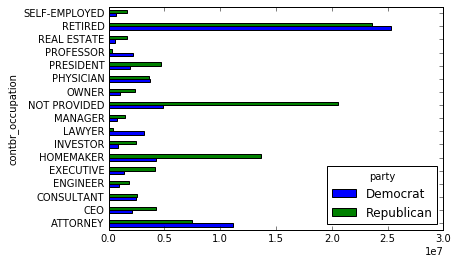

In [199]:
import matplotlib.pyplot as plt

# Visualize over_2mm:
over_2mm.plot(kind="barh")
plt.show()

In [215]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()
    
    # Order totals by key in descending order
    return totals.sort_values(ascending=False)[:n]

grouped = fec_mrbo.groupby('cand_nm')
grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

cand_nm        contbr_occupation                     
Obama, Barack  RETIRED                                   25305116.38
               ATTORNEY                                  11141982.97
               INFORMATION REQUESTED                      4866973.96
               HOMEMAKER                                  4248875.80
               PHYSICIAN                                  3735124.94
               LAWYER                                     3160478.87
               CONSULTANT                                 2459912.71
Romney, Mitt   RETIRED                                   11508473.59
               INFORMATION REQUESTED PER BEST EFFORTS    11396894.84
               HOMEMAKER                                  8147446.22
               ATTORNEY                                   5364718.82
               PRESIDENT                                  2491244.89
               EXECUTIVE                                  2300947.03
               C.E.O.                            

In [216]:
grouped.apply(get_top_amounts, 'contbr_employer', n=7)

cand_nm        contbr_employer                       
Obama, Barack  RETIRED                                   22694358.85
               SELF-EMPLOYED                             17080985.96
               NOT EMPLOYED                               8586308.70
               INFORMATION REQUESTED                      5053480.37
               HOMEMAKER                                  2605408.54
               SELF                                       1076531.20
               SELF EMPLOYED                               469290.00
Romney, Mitt   INFORMATION REQUESTED PER BEST EFFORTS    12059527.24
               RETIRED                                   11506225.71
               HOMEMAKER                                  8147196.22
               SELF-EMPLOYED                              7409860.98
               STUDENT                                     496490.94
               CREDIT SUISSE                               281150.00
               MORGAN STANLEY                    

### Bucketing Donation Amounts

A useful way to analyze this data is to use the cut function to discretize the contributor amounts into buckets by contribution size:

In [220]:
bins = np.array([0, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000])
labels = pd.cut(fec_mrbo.contb_receipt_amt, bins)
labels[:10]

411      (10, 100]
412    (100, 1000]
413    (100, 1000]
414      (10, 100]
415      (10, 100]
416      (10, 100]
417    (100, 1000]
418      (10, 100]
419    (100, 1000]
420      (10, 100]
Name: contb_receipt_amt, dtype: category
Categories (8, object): [(0, 1] < (1, 10] < (10, 100] < (100, 1000] < (1000, 10000] < (10000, 100000] < (100000, 1000000] < (1000000, 10000000]]

We can then group the data for Obama and Romney by name and bin label to get a histogram by donation size:

In [225]:
grouped = fec_mrbo.groupby(["cand_nm", labels])
grouped.size()

cand_nm        contb_receipt_amt  
Obama, Barack  (0, 1]                    493
               (1, 10]                 40070
               (10, 100]              372280
               (100, 1000]            153991
               (1000, 10000]           22284
               (10000, 100000]             2
               (100000, 1000000]           3
               (1000000, 10000000]         4
Romney, Mitt   (0, 1]                     77
               (1, 10]                  3681
               (10, 100]               31853
               (100, 1000]             43357
               (1000, 10000]           26186
               (10000, 100000]             1
dtype: int64

In [226]:
grouped.size().unstack(0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493.0,77.0
"(1, 10]",40070.0,3681.0
"(10, 100]",372280.0,31853.0
"(100, 1000]",153991.0,43357.0
"(1000, 10000]",22284.0,26186.0
"(10000, 100000]",2.0,1.0
"(100000, 1000000]",3.0,NaN
"(1000000, 10000000]",4.0,NaN


Sum the contribution amounts and normalize within buckets to visualize percentage of total donations of each size by candidate:

In [228]:
bucket_sums = grouped.contb_receipt_amt.sum()
bucket_sums

cand_nm        contb_receipt_amt  
Obama, Barack  (0, 1]                      318.24
               (1, 10]                  337267.62
               (10, 100]              20288981.41
               (100, 1000]            54798531.46
               (1000, 10000]          51753705.67
               (10000, 100000]           59100.00
               (100000, 1000000]       1490683.08
               (1000000, 10000000]     7148839.76
Romney, Mitt   (0, 1]                       77.00
               (1, 10]                   29819.66
               (10, 100]               1987783.76
               (100, 1000]            22363381.69
               (1000, 10000]          63942145.42
               (10000, 100000]           12700.00
Name: contb_receipt_amt, dtype: float64

In [230]:
bucket_sums = bucket_sums.unstack(0)
bucket_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",318.24,77.00
"(1, 10]",337267.62,29819.66
"(10, 100]",20288981.41,1987783.76
"(100, 1000]",54798531.46,22363381.69
"(1000, 10000]",51753705.67,63942145.42
"(10000, 100000]",59100.00,12700.00
"(100000, 1000000]",1490683.08,NaN
"(1000000, 10000000]",7148839.76,NaN


In [231]:
bucket_sums.sum(axis=1)

contb_receipt_amt
(0, 1]                 3.952400e+02
(1, 10]                3.670873e+05
(10, 100]              2.227677e+07
(100, 1000]            7.716191e+07
(1000, 10000]          1.156959e+08
(10000, 100000]        7.180000e+04
(100000, 1000000]      1.490683e+06
(1000000, 10000000]    7.148840e+06
dtype: float64

In [233]:
normalized_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0)
normalized_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,NaN
"(1000000, 10000000]",1.000000,NaN


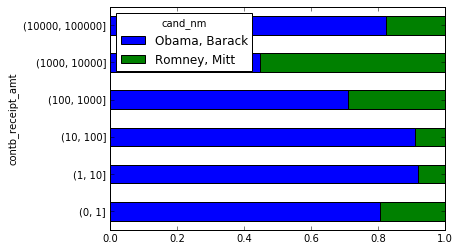

In [236]:
# plot it 
normalized_sums[:-2].plot(kind="barh", stacked=True)
plt.show()

### Donation Statistics by State

Aggregate data by candidate and state:

In [242]:
grouped = fec_mrbo.groupby(["cand_nm", "contbr_st"])
totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)
totals = totals[totals.sum(1) > 100000]
totals[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60
CO,2132429.49,1506714.12
CT,2068291.26,3499475.45
DC,4373538.80,1025137.50
DE,336669.14,82712.00


In [243]:
# Normalize each row
percent = totals.div(totals.sum(1), axis=0)
percent[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224
